# Import libraries

In [60]:
import pandas as pd
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch

# Load data

In [2]:
card_df = pd.read_csv("credit-card-data.csv")
card_df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
total_rows = len(card_df)
card_df.shape

(8950, 18)

# Missing Value Analysis

In [4]:
missing_val = pd.DataFrame(card_df.isnull().sum(), columns = ['Count'])
missing_val['Percentage'] = (missing_val.loc[:,'Count']*100)/len(card_df)

In [5]:
missing_val

,Count,Percentage
CUST_ID,0,0.000000
BALANCE,0,0.000000
BALANCE_FREQUENCY,0,0.000000
PURCHASES,0,0.000000
ONEOFF_PURCHASES,0,0.000000
INSTALLMENTS_PURCHASES,0,0.000000
CASH_ADVANCE,0,0.000000
PURCHASES_FREQUENCY,0,0.000000
ONEOFF_PURCHASES_FREQUENCY,0,0.000000
PURCHASES_INSTALLMENTS_FREQUENCY,0,0.000000


### Remove Missing values

In [6]:
# card_df.drop((card_df[card_df['CREDIT_LIMIT'].isnull() | card_df['MINIMUM_PAYMENTS'].isnull()]).index, inplace=True)
card_df.dropna(inplace=True)
print(f"DataLoss After removing missing values : {total_rows-len(card_df)}")

DataLoss After removing missing values : 314


In [7]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8636 entries, 0 to 8949
Data columns (total 18 columns):
CUST_ID                             8636 non-null object
BALANCE                             8636 non-null float64
BALANCE_FREQUENCY                   8636 non-null float64
PURCHASES                           8636 non-null float64
ONEOFF_PURCHASES                    8636 non-null float64
INSTALLMENTS_PURCHASES              8636 non-null float64
CASH_ADVANCE                        8636 non-null float64
PURCHASES_FREQUENCY                 8636 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8636 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8636 non-null float64
CASH_ADVANCE_FREQUENCY              8636 non-null float64
CASH_ADVANCE_TRX                    8636 non-null int64
PURCHASES_TRX                       8636 non-null int64
CREDIT_LIMIT                        8636 non-null float64
PAYMENTS                            8636 non-null float64
MINIMUM_PAYMENTS            

# 1. Deriving key performance indicators(KPI)

- 1.1 - monthly average purchase
- 1.2 - monthly cash advance amount
- 1.3 - purchases by type (one-off, instalments)
- 1.4 - average amount per purchase
- 1.5 - cash advance transaction
- 1.6 - limit usage (balance to credit limit ratio)
- 1.7 - payments to minimum payments ratio 


In [14]:
# TENURE Number of months as a customer
card_df_KPI = pd.DataFrame(card_df['CUST_ID'])
card_df.TENURE.unique()

array([12,  8, 11,  9, 10,  6,  7], dtype=int64)

### 1.1 - monthly average purchase

In [15]:
# PURCHASES Total purchase amount spent during last 12 months
card_df_KPI['monthly_avg_purchase'] = card_df.PURCHASES / card_df.TENURE
card_df_KPI.head()

,CUST_ID,monthly_avg_purchase
0,C10001,7.950000
1,C10002,0.000000
2,C10003,64.430833
4,C10005,1.333333
5,C10006,111.106667


### 1.2 - monthly cash advance amount

In [16]:
card_df_KPI['monthly_cash_advance'] = card_df.CASH_ADVANCE / card_df.TENURE
card_df_KPI.head()

,CUST_ID,monthly_avg_purchase,monthly_cash_advance
0,C10001,7.950000,0.000000
1,C10002,0.000000,536.912124
2,C10003,64.430833,0.000000
4,C10005,1.333333,0.000000
5,C10006,111.106667,0.000000


### 1.3 - monthly purchases by type (one-off, instalments)

In [17]:
card_df_KPI['monthly_oneoff_purchase'] = card_df.ONEOFF_PURCHASES / card_df.TENURE
card_df_KPI['monthly_installment_purchase'] = card_df.INSTALLMENTS_PURCHASES / card_df.TENURE
card_df_KPI.head()

,CUST_ID,monthly_avg_purchase,monthly_cash_advance,monthly_oneoff_purchase,monthly_installment_purchase
0,C10001,7.950000,0.000000,0.000000,7.950000
1,C10002,0.000000,536.912124,0.000000,0.000000
2,C10003,64.430833,0.000000,64.430833,0.000000
4,C10005,1.333333,0.000000,1.333333,0.000000
5,C10006,111.106667,0.000000,0.000000,111.106667


### 1.4 - average amount per purchase

### 1.5 - average cash advance transaction

### 1.6 - limit usage (balance to credit limit ratio)

### 1.7 - payments to minimum payments ratio

# 2. Advanced reporting. Use the derived KPI’s to gain insight on the customer profiles.


# 3. Clustering

In [22]:
card_df.drop('CUST_ID', axis=1,inplace=True)

## 3.1 Dimensionality Reduction - Factor Analysis

Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis


In [24]:
chi_square_value,p_value=calculate_bartlett_sphericity(card_df)
print(chi_square_value, p_value)

168083.73666436694 0.0


##### In this Bartlett ’s test, the p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.


Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [27]:
kmo_all,kmo_model=calculate_kmo(card_df)
kmo_model

0.640839934787457

###### Here kmo_model value is 0.64, so it is adequate.

### Choosing the Number of Factors

#### Way 1

In [ ]:
## fa = FactorAnalyzer()
fa.set_params(n_factors=25, rotation=None)
fa.fit(card_df)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

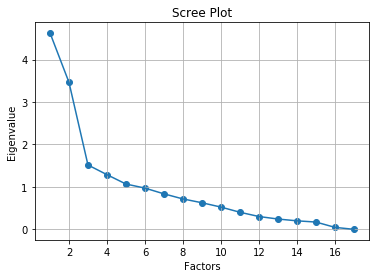

In [33]:
# Create scree plot using matplotlib
plt.scatter(range(1,card_df.shape[1]+1),ev)
plt.plot(range(1,card_df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

The scree plot method draws a straight line for each factor and its eigenvalues. Number eigenvalues greater than one considered as the number of factors.

Here, you can see only for 5-factors eigenvalues are greater than one. It means we need to choose only 5 factors (or unobserved variables).

In [36]:
fa = FactorAnalyzer()
fa.set_params(n_factors=5, rotation="varimax")
fa.fit(card_df)

loadings = fa.loadings_
loadings

array([[ 0.18029785,  0.34677472, -0.07306081,  0.91742164,  0.05550782],
       [-0.00838191,  0.11757016,  0.19849389,  0.31880373,  0.23552806],
       [ 0.94857243, -0.11756566,  0.22453622,  0.06897667,  0.14497375],
       [ 0.81818849, -0.08112977,  0.01525341,  0.02052414,  0.29695298],
       [ 0.53246762, -0.09373773,  0.49529084,  0.13419223, -0.1027712 ],
       [ 0.11915311,  0.75416205, -0.10655874,  0.21768563, -0.09835367],
       [ 0.14851412, -0.17252302,  0.84869453, -0.03181749,  0.36799687],
       [ 0.39021439, -0.08202159,  0.15442663, -0.00339506,  0.78122788],
       [ 0.0946085 , -0.13300364,  0.95610177,  0.02417426, -0.02606157],
       [-0.05599638,  0.83200196, -0.16095807,  0.17331725,  0.02385145],
       [ 0.00904642,  0.86422506, -0.05937124,  0.10065834,  0.01534091],
       [ 0.55536931, -0.09500852,  0.49028328,  0.12847527,  0.26567758],
       [ 0.40295058,  0.17074663,  0.04738432,  0.35069728,  0.12117731],
       [ 0.71921649,  0.32247988,  0.0

#### Way 2

In [44]:
sk_fa = FactorAnalysis(n_components=5, random_state=0)
sk_fa.fit(card_df)
sk_fa.components_

array([[ 6.39416983e+02,  2.73071557e-02,  2.08923058e+03,
         1.48443962e+03,  6.04849731e+02,  8.54703375e+01,
         1.50291699e-01,  1.53869301e-01,  1.16197337e-01,
        -1.41141662e-02, -1.22672864e-01,  1.69314094e+01,
         2.16942257e+03,  1.87573291e+03,  2.87067183e+02,
         4.94061305e-02,  1.46738925e-01],
       [-9.32340626e+02, -2.84301036e-03,  5.74025460e+02,
         4.23005073e+02,  1.51105316e+02, -7.44329173e+02,
         5.07400965e-02,  3.58400020e-03,  5.45866270e-02,
        -4.42641823e-02, -1.39998834e+00,  3.90882740e+00,
        -2.94510777e+03, -1.65214606e+02, -1.87093315e+02,
         1.77556582e-02, -1.14401410e-01],
       [ 7.04362842e+02,  2.49010164e-02, -4.21364799e+00,
        -6.51883335e+01,  6.09222365e+01,  2.48019403e+02,
        -1.45884978e-02, -2.83461944e-02,  1.30224301e-03,
         2.04022954e-02,  7.36227401e-01,  6.82003499e-01,
        -3.17900873e+01,  1.40103724e+02,  2.33825412e+03,
        -4.80030557e-02,  5.0

In [45]:
sk_fa.components_.shape

(5, 17)

In [50]:
X_fa = sk_fa.transform(card_df)
X_fa

array([[-0.64526484,  0.7222885 , -0.17485668,  0.51083336, -0.70268377],
       [-0.21680528, -1.00339084,  0.04469841,  0.91004019,  0.20066502],
       [ 0.1301241 , -0.91165766, -0.20097186,  0.11461564, -1.03025201],
       ...,
       [-0.62346696,  0.74001887, -0.20453677, -0.88520893, -0.00339987],
       [-0.72265719,  0.83449784, -0.18929567,  0.88452422, -0.25609005],
       [-0.23228016,  0.9575589 , -0.22552807,  0.78221009,  0.1581589 ]])

In [51]:
X_fa.shape

(8636, 5)

## 3.2 - K-Means Clustering

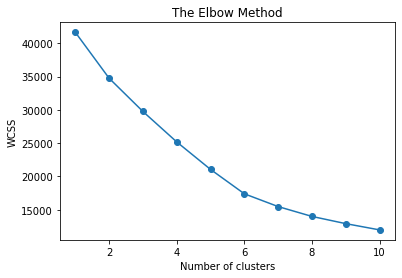

In [57]:
## Reduced data
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_fa)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11), wcss, marker="o")
plt.title('The Elbow Method for reduced data')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

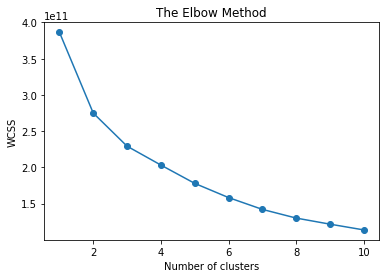

In [58]:
## card_df
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(card_df)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11), wcss, marker="o")
plt.title('The Elbow Method for Card dataframe')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## 3.3 Hierarchical Clustering

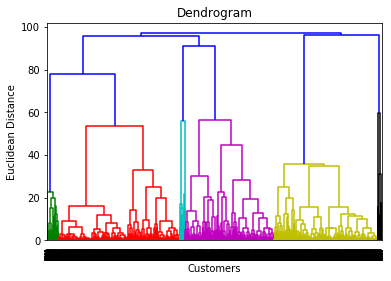

In [61]:
## Reduced data
dendrogram = sch.dendrogram(sch.linkage(X_fa, method='ward'))
plt.title('Dendrogram For Reduced Data')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()

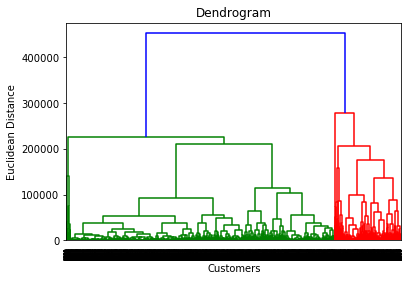

In [62]:
## card_df
dendrogram = sch.dendrogram(sch.linkage(card_df, method='ward'))
plt.title('Dendrogram for Card dataframe')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()